In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import string
import re
from collections import Counter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.api.types import is_string_dtype, is_numeric_dtype    
plt.style.use('ggplot')


Bad key "backend.qt4" on line 43 in
/etc/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import chardet
with open('train.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

1. Leo el archivo de train

In [3]:
df_completo = pd.read_csv("train.csv",";")
df_completo.drop(['Unnamed: 0'], axis=1, inplace=True)
print(df_completo.shape)
df_completo.head(3)

(44678, 16)


,id,start_date,end_date,created_on,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,title,description,barrio_aumentado
0,0,2020-05-09,2020-07-03,2020-05-09,"-34,5722317","-58,4314464",palermo,2.0,1.0,1.0,80.0,NaN,235000.0,departamento - las caã±itas,duplex en venta - excelente propiedad<br><b...,palermo
1,1,2020-05-09,2021-05-29,2020-05-09,"-34,553906","-58,4520949",belgrano,NaN,NaN,1.0,NaN,40.0,105000.0,espectacular monoambiente en belgrano!!,apto todo destino espectacular monoambiente de...,belgrano
2,2,2020-05-09,2020-05-28,2020-05-09,NaN,NaN,san telmo,1.0,NaN,1.0,34.0,31.0,109183.0,venta emprendimiento 9 de julio estudios 1 y 2...,venta emprendimiento 9 de julio estudios 1 y 2...,san telmo


2. Convierto en numerico las coordenadas

In [ ]:
df_completo['lat'] = df_completo['lat'].str.replace(",", ".")
df_completo['lat'] = df_completo['lat'].astype(float)

df_completo['lon'] = df_completo['lon'].str.replace(",", ".")
df_completo['lon'] = df_completo['lon'].astype(float)


3. Corrijo algunas variables

In [4]:
df_completo['description'] = df_completo['description'].str.replace("baño","banio")
df_completo['description'] = df_completo['description'].str.replace("balcón","balcon")
df_completo['description'] = df_completo['description'].str.replace("balcã³n","balcon")


df_completo['description'] = df_completo['description'].str.replace("antigüedad","antiguedad")
df_completo['description'] = df_completo['description'].str.replace("años","anios")
df_completo['description'] = df_completo['description'].str.replace("año","anio")
df_completo['description'] = df_completo['description'].str.replace("dúplex","duplex")
df_completo['description'] = df_completo['description'].str.replace("baã±o","banio")
df_completo['description'] = df_completo['description'].str.replace("agã¼ero","aguero")
df_completo['description'] = df_completo['description'].str.replace("pueyrredã³n","pueyrredon")
df_completo['description'] = df_completo['description'].str.replace("mã¡s","mas")
df_completo['description'] = df_completo['description'].str.replace("despuã©s","despues")


df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("las caÃ±itas","palermo")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("centro / microcentro","san nicolas")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("tribunales","san nicolas")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("abasto","balvanera")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("congreso","balvanera")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("once","balvanera")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("parque centenario","caballito")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("san nicolÃ¡s","san nicolas")
df_completo['barrio_aumentado'] = df_completo['barrio_aumentado'].str.replace("villa gral. mitre","villa gral mitre")


4. Retiro del conjunto de datos las fechas, longitud y latitud

In [5]:
df_completo.drop(['start_date', 'end_date', 'created_on','l3','lat','lon'], axis = 1, inplace = True)
df_completo.rename({'barrio_aumentado': 'barrio'}, axis=1, inplace=True)

5. Corrijo aquellos valores donde la superficie total es mayor a la cubierta

In [6]:
wrong_surface_rows = df_completo[df_completo['surface_total']<df_completo['surface_covered']]
wrong_surface_rows.shape

(96, 10)

In [7]:
df_completo.at[wrong_surface_rows.index, 'surface_total'] = wrong_surface_rows.surface_covered
df_completo.at[wrong_surface_rows.index, 'surface_covered'] = wrong_surface_rows.surface_total

6. LLeno con 1 el campo bathrooms que esten vacios

In [ ]:
wrong_bathrooms_rows = df_completo[df_completo['bathrooms'].isnull()]
wrong_bathrooms_rows.shape

In [ ]:
df_completo.at[wrong_bathrooms_rows.index, 'bathrooms'] = 1

7. Miro los datos faltantes

Datos faltantes
id                    0
rooms              1131
bedrooms           6055
bathrooms          1307
surface_total      4822
surface_covered    4037
price                 0
title                 0
description           0
barrio              475
dtype: int64


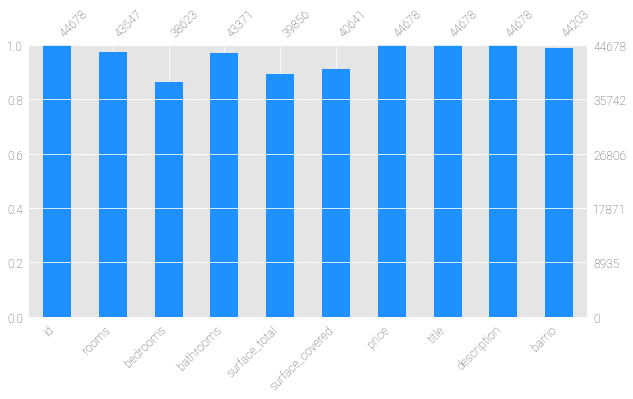

In [8]:
print("Datos faltantes")
print(df_completo.isnull().sum())
plt.style.use('ggplot')
msno.bar(df_completo, figsize=(10,5), color="dodgerblue", fontsize=12)

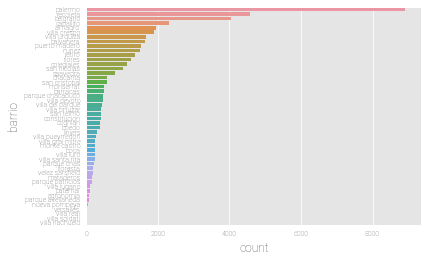

In [9]:
sns.countplot(y = 'barrio',
              data = df_completo,
              order = df_completo['barrio'].value_counts().index)
plt.show()

In [10]:
## Separamos entre las variable numericas y categoricas
num_list = []
cat_list = []

for column in df_completo:
    if is_numeric_dtype(df_completo[column]):
        num_list.append(column)
    elif is_string_dtype(df_completo[column]):
        cat_list.append(column)
print('Categoricas: ', cat_list)
print('Numercias: ', num_list)


Categoricas:  ['title', 'description', 'barrio']
Numercias:  ['id', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']


/home/cdsw/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

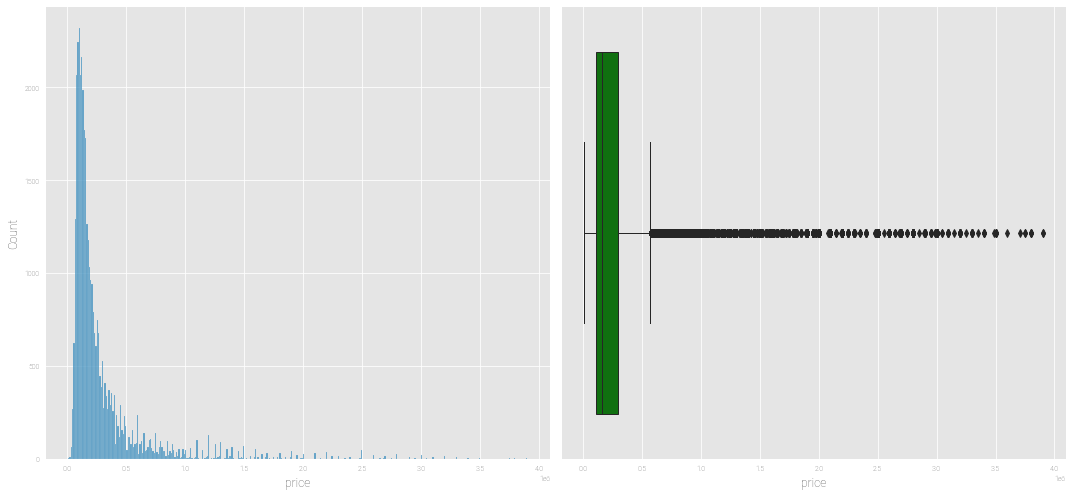

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.histplot(df_completo["price"],ax = axes[0])
sns.boxplot(df_completo["price"],ax = axes[1],color="g")

plt.tight_layout()
plt.show()
plt.gcf().clear()


In [22]:
df_completo.price.describe()

count    3.788300e+04
mean     2.828652e+05
std      3.589853e+05
min      7.000000e+03
25%      1.100000e+05
50%      1.650000e+05
75%      2.950000e+05
max      3.900000e+06
Name: price, dtype: float64

In [13]:
df_completo = df_completo[df_completo['price'] > df_completo.price.min()]
df_completo = df_completo[df_completo['price'] < 4000000.0]

/home/cdsw/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

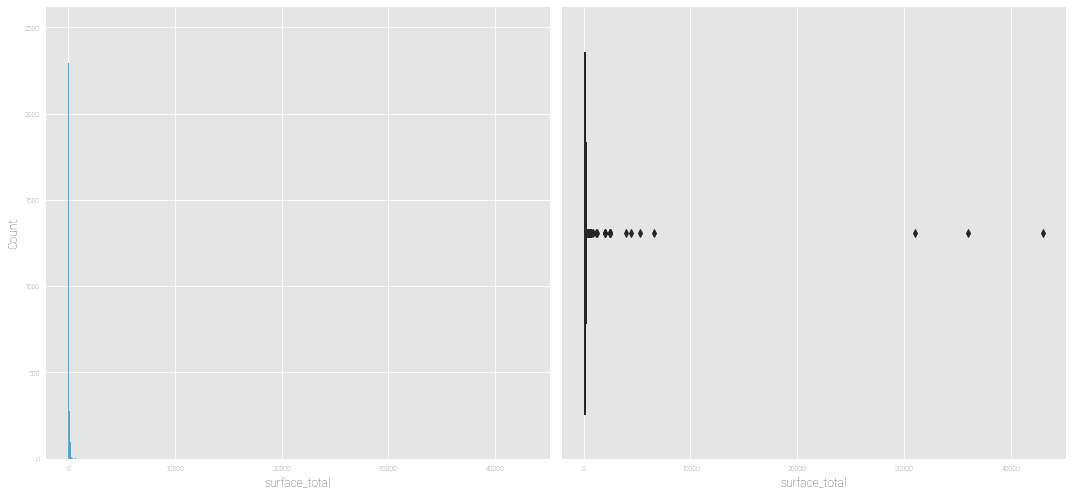

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.histplot(df_completo["surface_total"],ax = axes[0])
sns.boxplot(df_completo["surface_total"],ax = axes[1],color="g")

plt.tight_layout()
plt.show()
plt.gcf().clear()


In [15]:
df_completo.surface_total.describe()

count    39818.000000
mean        90.506932
std        333.956947
min         10.000000
25%         44.000000
50%         64.000000
75%        100.000000
max      43000.000000
Name: surface_total, dtype: float64

In [16]:
df_completo = df_completo[df_completo['surface_total'] <  900]

/home/cdsw/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

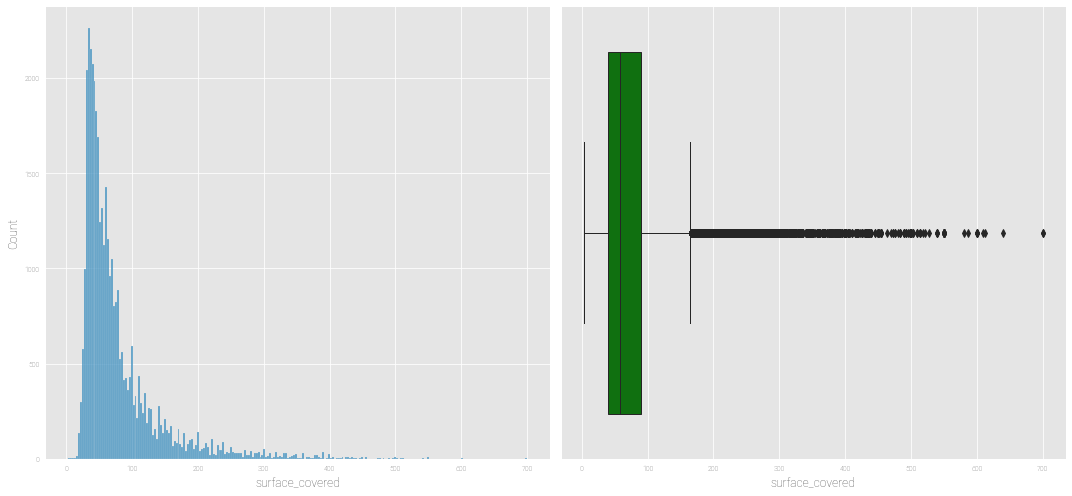

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.histplot(df_completo["surface_covered"],ax = axes[0])
sns.boxplot(df_completo["surface_covered"],ax = axes[1],color="g")

plt.tight_layout()
plt.show()
plt.gcf().clear()


In [18]:
df_completo.surface_covered.describe()

count    37903.000000
mean        78.111284
std         63.663837
min          3.000000
25%         40.000000
50%         58.000000
75%         90.000000
max        700.000000
Name: surface_covered, dtype: float64

In [23]:
df_completo = df_completo[df_completo['surface_covered'] > 15] #Pensando que son monoambientes

In [24]:
for var in ['surface_total', 'surface_covered', 'price']:
    scaled_var = "scaled_" + var
    df_completo[scaled_var] = np.log1p(df_completo[var])

In [25]:
df_completo.columns

Index(['id', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'title', 'description', 'barrio',
       'scaled_surface_total', 'scaled_surface_covered', 'scaled_price'],
      dtype='object')

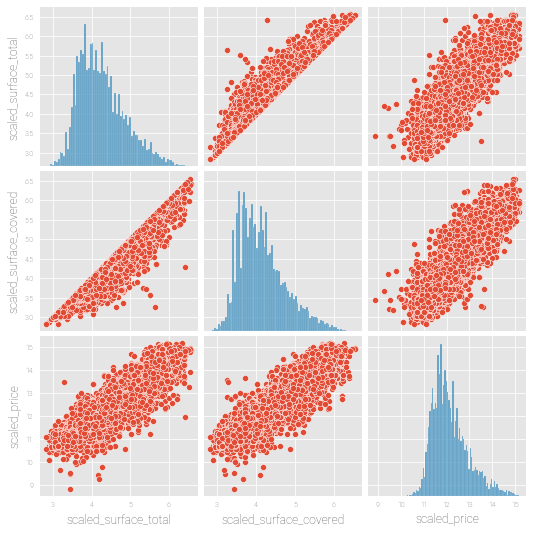

In [26]:
sns.pairplot(df_completo[ ['scaled_surface_total', 'scaled_surface_covered','scaled_price']])

In [28]:
df_completo[ ['scaled_surface_total', 'scaled_surface_covered','scaled_price']].corr()

,scaled_surface_total,scaled_surface_covered,scaled_price
scaled_surface_total,1.000000,0.973525,0.891319
scaled_surface_covered,0.973525,1.000000,0.895558
scaled_price,0.891319,0.895558,1.000000


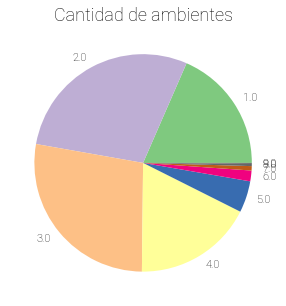

In [39]:
#Se filtra las propiedades con más de 6 cuartos
properati_room = df_completo.loc[df_completo.rooms < 10,['rooms','price']]
grouped_rooms = properati_room.groupby('rooms').size().plot(kind='pie', figsize=(5,5),cmap='Accent',fontsize=11)
plt.title('Cantidad de ambientes', fontsize = 18)
plt.ylabel('')
plt.show();

In [35]:
wrong_room_rows = df_completo[df_completo['rooms'] >= 11]
df_completo.at[wrong_room_rows.index, 'rooms'] = np.NaN

In [36]:
wrong_room_rows = df_completo[df_completo['bedrooms'] > 10]
df_completo.at[wrong_room_rows.index, 'bedrooms'] = np.NaN

In [37]:
wrong_room_rows = df_completo[df_completo['bathrooms'] > 8]
df_completo.at[wrong_room_rows.index, 'bathrooms'] = np.NaN

Text(0.5, 0, 'cantidad de ambientes')

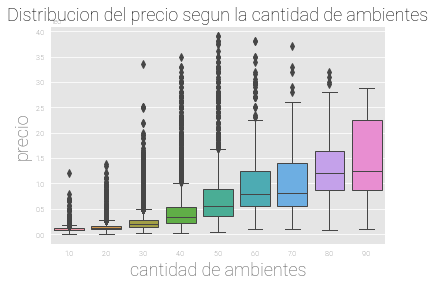

In [40]:
g = sns.boxplot(x='rooms',y='price',data=properati_room)
g.set_ylabel('precio',size=18)
g.set_title('Distribucion del precio segun la cantidad de ambientes',fontsize=18),
g.set_xlabel('cantidad de ambientes',size=18)

In [44]:
properati_bathrooms = df_completo.loc[df_completo.rooms < 11,['bathrooms','price']]

Text(0.5, 0, 'cantidad de habitaciones')

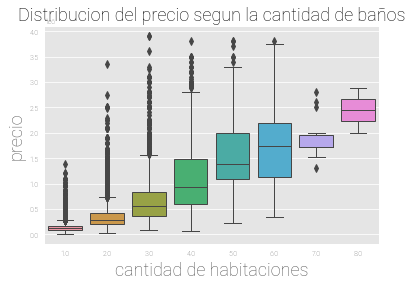

In [45]:
g = sns.boxplot(x='bathrooms',y='price',data=properati_bathrooms)
g.set_ylabel('precio',size=18)
g.set_title('Distribucion del precio segun la cantidad de baños',fontsize=18),
g.set_xlabel('cantidad de habitaciones',size=18)

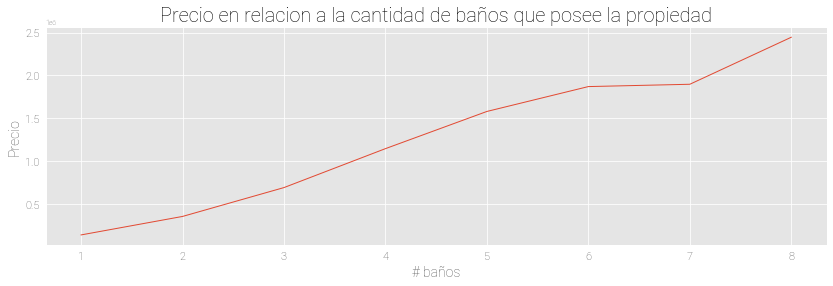

In [47]:
properati_bathrooms.groupby('bathrooms').mean()['price'].plot(figsize=(14,4),fontsize=11);
plt.title('Precio en relacion a la cantidad de baños que posee la propiedad', fontsize= 20);
plt.xlabel('# baños', fontsize = 14);
plt.ylabel('Precio', fontsize=14);
plt.show();

In [48]:
df_completo[['rooms', 'bedrooms','bathrooms','scaled_price']].corr()

,rooms,bedrooms,bathrooms,scaled_price
rooms,1.000000,0.888824,0.664707,0.719859
bedrooms,0.888824,1.000000,0.698262,0.672986
bathrooms,0.664707,0.698262,1.000000,0.766591
scaled_price,0.719859,0.672986,0.766591,1.000000


Datos faltantes
id                           0
rooms                      631
bedrooms                  4772
bathrooms                  610
surface_total                0
surface_covered              0
price                        0
title                        0
description                  0
barrio                     453
scaled_surface_total         0
scaled_surface_covered       0
scaled_price                 0
dtype: int64


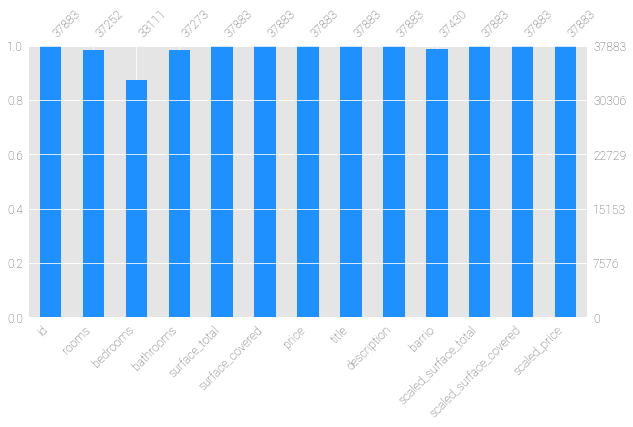

In [50]:
print("Datos faltantes")
print(df_completo.isnull().sum())
plt.style.use('ggplot')
msno.bar(df_completo, figsize=(10,5), color="dodgerblue", fontsize=12)

In [51]:
df_completo = df_completo.reset_index(drop = True)

In [52]:
na_rooms_rows = df_completo[df_completo['rooms'].isnull()]
df_completo.at[na_rooms_rows.index, 'rooms'] = na_rooms_rows.bathrooms + 1

In [53]:
df_completo.drop(['bedrooms'], axis=1, inplace=True)

In [54]:
df_completo = df_completo.dropna().reset_index(drop = True)

In [55]:
df_completo[['rooms', 'bathrooms','scaled_price']].corr()

,rooms,bathrooms,scaled_price
rooms,1.000000,0.668454,0.719143
bathrooms,0.668454,1.000000,0.767840
scaled_price,0.719143,0.767840,1.000000


In [56]:
minimo=df_completo.price.min()
maximo=df_completo.price.max()
media=df_completo.price.mean()
mediana=df_completo.price.median()
desv_estandar=df_completo.price.std()

print('maximo = {a}\nminimo: {b}\nmedia= {c}\nmediana= {d}\ndesvio estandar = {e}' .format(a=maximo, b=minimo, c=media, d=mediana, e=desv_estandar))

maximo = 3900000.0
minimo: 10500.0
media= 284699.8150562164
mediana= 165000.0
desvio estandar = 362010.7765523808


In [57]:
# Mostrá los cuartiles en esta celda
df_completo.price.quantile([0.25,0.75])

0.25    110000.0
0.75    295000.0
Name: price, dtype: float64

In [58]:
Q1= df_completo.price.quantile(0.25)
Q3= df_completo.price.quantile(0.75)
IQR = Q3 - Q1
IQR

185000.0

In [59]:
mask = df_completo['price']
p10 = np.percentile(mask, 10)
p90 = np.percentile(mask, 90)

df_filtered = df_completo[(df_completo.price >= p10) & (df_completo.price <= p90)]

In [60]:
# Realizá los calculos en esta celda
maximo=df_filtered.price.max()
media=df_filtered.price.mean()
mediana=df_filtered.price.median()
desv_estandar=df_filtered.price.std()

print('maximo = {a}\nminimo: {b}\nmedia= {c}\nmediana= {d}\ndesvio estandar = {e}' .format(a=maximo, b=minimo, c=media, d=mediana, e=desv_estandar))

maximo = 590000.0
minimo: 10500.0
media= 203695.7564684903
mediana= 165000.0
desvio estandar = 115198.73281932506


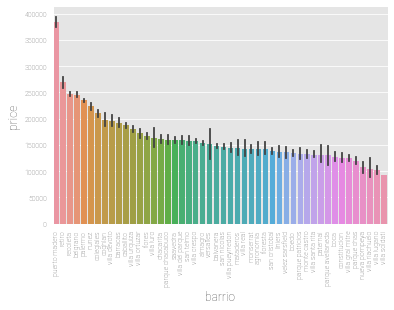

In [61]:
plt.xticks(rotation = 90)
barrios = df_filtered.groupby('barrio').mean().sort_values('price', ascending=False).index
sns.barplot(x="barrio", y="price", order=barrios, data=df_filtered);

In [64]:
table = pd.pivot_table(df_filtered, values='price', index=['barrio'], aggfunc=np.mean)
print("-- Barrios costosos --")
mas_caros = table.sort_values('price', ascending=False).iloc[:5]
mas_caros

-- Barrios costosos --


,price
barrio,
puerto madero,384823.897826
retiro,269583.183099
recoleta,247308.653005
belgrano,245307.360787
palermo,234817.605943


In [65]:
table = pd.pivot_table(df_filtered, values='price', index=['barrio'], aggfunc=np.mean)
print("-- Barrios baratos --")
mas_baratos = table.sort_values('price', ascending=True).iloc[:5]
mas_baratos

-- Barrios baratos --


,price
barrio,
villa soldati,92000.000000
villa lugano,102466.666667
villa riachuelo,105000.000000
nueva pompeya,107154.545455
parque chas,119827.841772


In [66]:
df_completo["barrio"] = df_completo["barrio"].str.replace(" ", "")
df_completo["barrio"].unique()

array(['santelmo', 'palermo', 'puertomadero', 'villadevoto',
       'villasantarita', 'villaurquiza', 'parquechas', 'belgrano',
       'colegiales', 'villareal', 'boedo', 'balvanera', 'sannicolas',
       'barracas', 'villacrespo', 'recoleta', 'chacarita',
       'villapueyrredon', 'almagro', 'flores', 'nunez', 'sancristobal',
       'caballito', 'monserrat', 'montecastro', 'nuevapompeya', 'retiro',
       'liniers', 'villalugano', 'villagralmitre', 'velezsarsfield',
       'floresta', 'parqueavellaneda', 'paternal', 'villaortuzar',
       'saavedra', 'villaluro', 'versalles', 'parquechacabuco', 'coghlan',
       'constitucion', 'villadelparque', 'villariachuelo', 'boca',
       'mataderos', 'agronomia', 'parquepatricios', 'villasoldati'],
      dtype=object)

In [67]:
df_trenes = pd.read_csv("conteo_trenes.csv")
df_trenes.head()

,barrio_aumentado,n
0,palermo,3
1,belgrano,2
2,nunez,2
3,retiro,2
4,villasoldati,2


In [68]:
df_subte = pd.read_csv("conteo_bocas_subte.csv")
df_subte.head()

,barrio_aumentado,n
0,balvanera,57
1,sannicolas,52
2,monserrat,38
3,palermo,25
4,almagro,20


In [69]:
df_completo['bocas_subte'] = 0
for exp in range(0,df_subte.shape[0]):
    bocas_subte_rows = df_completo[df_completo['barrio'] == df_subte['barrio_aumentado'][exp]]
    df_completo.at[bocas_subte_rows.index, 'bocas_subte'] = df_subte['n'][exp]


In [70]:
df_completo['estacion_tren'] = 0
for exp in range(0,df_trenes.shape[0]):
    estacion_tren_rows = df_completo[df_completo['barrio'] == df_trenes['barrio_aumentado'][exp]]
    df_completo.at[estacion_tren_rows.index, 'estacion_tren'] = df_trenes['n'][exp]
df_completo.head(3)

,id,rooms,bathrooms,surface_total,surface_covered,price,title,description,barrio,scaled_surface_total,scaled_surface_covered,scaled_price,bocas_subte,estacion_tren
0,2,1.0,1.0,34.0,31.0,109183.0,venta emprendimiento 9 de julio estudios 1 y 2...,venta emprendimiento 9 de julio estudios 1 y 2...,santelmo,3.555348,3.465736,11.600790,0,0
1,4,6.0,2.0,190.0,178.0,550000.0,venta departamento 4 dormitorios mas depend. e...,venta piso de 6 ambientes en 190 m2 totales e...,palermo,5.252273,5.187386,13.217675,25,3
2,7,3.0,3.0,161.0,149.0,1600000.0,espectacular departamento en alvear tower!!!,el edificio esta ubicado cercano a varios siti...,puertomadero,5.087596,5.010635,14.285515,0,0


Text(0.5, 0, '# Estaciones cercanas')

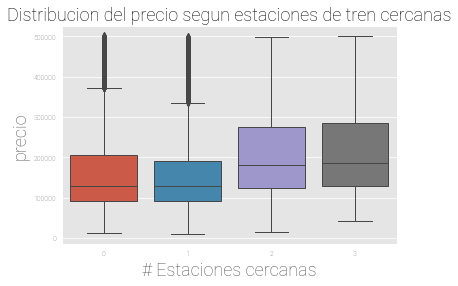

In [86]:
properati_tren = df_completo.loc[df_completo.price < 900000,['estacion_tren','price']]

g = sns.boxplot(x='estacion_tren',y='price',data=properati_tren)
g.set_ylabel('precio',size=18)
g.set_title('Distribucion del precio segun estaciones de tren cercanas',fontsize=18),
g.set_xlabel('# Estaciones cercanas',size=18)

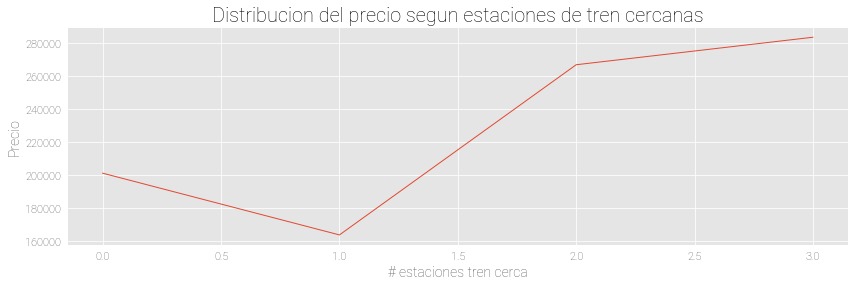

In [91]:
properati_tren = df_completo.loc[df_completo.price < 1000000,['estacion_tren','price']]

properati_tren.groupby('estacion_tren').mean()['price'].plot(figsize=(14,4),fontsize=11);

plt.title('Distribucion del precio segun estaciones de tren cercanas', fontsize= 20);
plt.xlabel('# estaciones tren cerca', fontsize = 14);
plt.ylabel('Precio', fontsize=14);
plt.show();

Text(0.5, 0, '# bocas de subte')

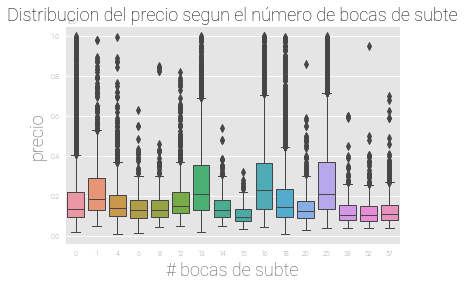

In [94]:
properati_tren = df_completo.loc[df_completo.price < 1000000,['bocas_subte','price']]

g = sns.boxplot(x='bocas_subte',y='price',data=properati_tren)
g.set_ylabel('precio',size=18)
g.set_title('Distribucion del precio segun el número de bocas de subte',fontsize=18),
g.set_xlabel('# bocas de subte',size=18)

In [95]:
df_expensas = pd.read_csv("expensas.csv")
df_expensas['barrio'] = df_expensas['barrio'].str.lower()
df_expensas.barrio = df_expensas.barrio.str.replace(' ', '')
df_expensas.head()

,barrio,expensas
0,agronomia,2396.49
1,almagro,3652.52
2,balvanera,3477.26
3,barracas,3695.70
4,belgrano,4577.08


In [72]:
df_completo['expensas'] = np.NaN
for exp in range(0,df_expensas.shape[0]):
    expensas_rows = df_completo[df_completo['barrio'] == df_expensas['barrio'][exp]]
    df_completo.at[expensas_rows.index, 'expensas'] = df_expensas['expensas'][exp]

In [97]:
for var in ['expensas']:
    scaled_var = "scaled_" + var
    df_completo[scaled_var] = np.log1p(df_completo[var])

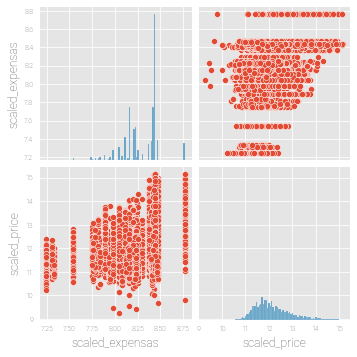

In [98]:
sns.pairplot(df_completo[['scaled_expensas','scaled_price']])

In [99]:
df_completo[['scaled_expensas','scaled_price']].corr()

,scaled_expensas,scaled_price
scaled_expensas,1.000000,0.450306
scaled_price,0.450306,1.000000


In [102]:
df_completo.columns

Index(['id', 'rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price',
       'title', 'description', 'barrio', 'scaled_surface_total',
       'scaled_surface_covered', 'scaled_price', 'bocas_subte',
       'estacion_tren', 'expensas', 'scaled_expensas'],
      dtype='object')

In [103]:
my_r = df_completo[['rooms', 'bathrooms','scaled_surface_total',
       'scaled_surface_covered', 'scaled_price', 'bocas_subte',
       'estacion_tren', 'scaled_expensas']].corr(method="spearman")
my_r

,rooms,bathrooms,scaled_surface_total,scaled_surface_covered,scaled_price,bocas_subte,estacion_tren,scaled_expensas
rooms,1.000000,0.684667,0.858656,0.884280,0.737590,0.040313,0.070467,0.143901
bathrooms,0.684667,1.000000,0.740469,0.746908,0.737205,0.027529,0.127840,0.262533
scaled_surface_total,0.858656,0.740469,1.000000,0.968701,0.879843,-0.005807,0.107853,0.231104
scaled_surface_covered,0.884280,0.746908,0.968701,1.000000,0.877118,0.015334,0.104164,0.251963
scaled_price,0.737590,0.737205,0.879843,0.877118,1.000000,0.027370,0.234848,0.430337
bocas_subte,0.040313,0.027529,-0.005807,0.015334,0.027370,1.000000,0.407931,0.300486
estacion_tren,0.070467,0.127840,0.107853,0.104164,0.234848,0.407931,1.000000,0.448233
scaled_expensas,0.143901,0.262533,0.231104,0.251963,0.430337,0.300486,0.448233,1.000000


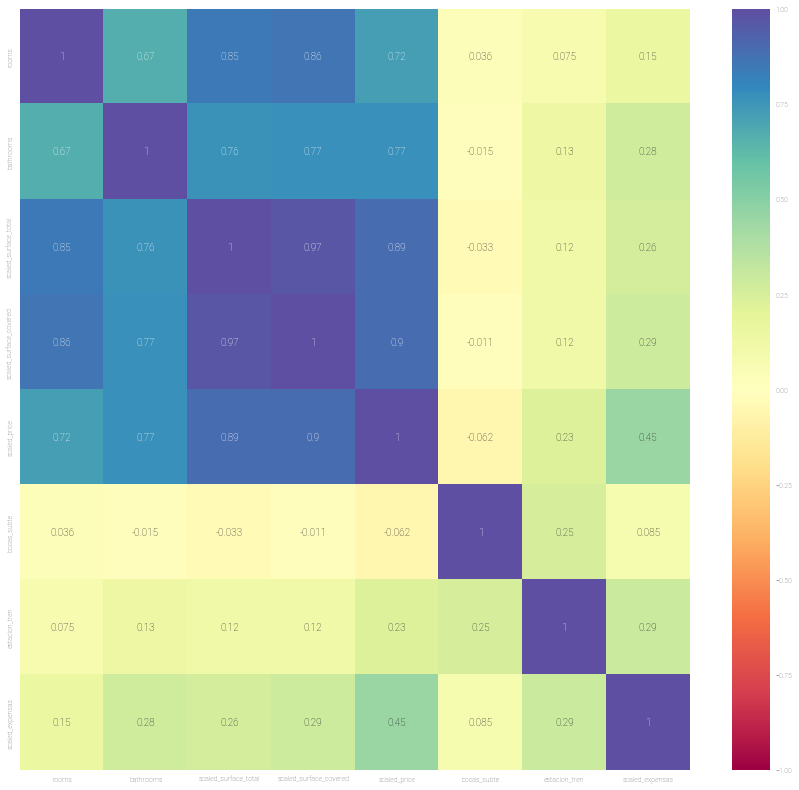

In [104]:
# Se grafican las correlaciones entre las variables
plt.figure(figsize=(15, 14))
sns.heatmap( df_completo[['rooms', 'bathrooms','scaled_surface_total',
       'scaled_surface_covered', 'scaled_price', 'bocas_subte',
       'estacion_tren', 'scaled_expensas']].corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)
plt.show()

In [100]:
print("Datos faltantes")
print(df_completo.isnull().sum())

Datos faltantes
id                        0
rooms                     0
bathrooms                 0
surface_total             0
surface_covered           0
price                     0
title                     0
description               0
barrio                    0
scaled_surface_total      0
scaled_surface_covered    0
scaled_price              0
bocas_subte               0
estacion_tren             0
expensas                  0
scaled_expensas           0
dtype: int64


12. Análisis de texto

In [107]:
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = list(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /home/cdsw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cdsw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [116]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de saltos
    nuevo_texto = re.sub("br", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
        
    return(nuevo_texto)


In [112]:
df_filtered = df_completo.reset_index(drop = True)
df_filtered.head(3)

,id,rooms,bathrooms,surface_total,surface_covered,price,title,description,barrio,scaled_surface_total,scaled_surface_covered,scaled_price,bocas_subte,estacion_tren,expensas,scaled_expensas
0,2,1.0,1.0,34.0,31.0,109183.0,venta emprendimiento 9 de julio estudios 1 y 2...,venta emprendimiento 9 de julio estudios 1 y 2...,santelmo,3.555348,3.465736,11.600790,0,0,4732.02,8.462319
1,4,6.0,2.0,190.0,178.0,550000.0,venta departamento 4 dormitorios mas depend. e...,venta piso de 6 ambientes en 190 m2 totales e...,palermo,5.252273,5.187386,13.217675,25,3,4611.37,8.436497
2,7,3.0,3.0,161.0,149.0,1600000.0,espectacular departamento en alvear tower!!!,el edificio esta ubicado cercano a varios siti...,puertomadero,5.087596,5.010635,14.285515,0,0,6418.58,8.767108


In [129]:
test = df_filtered['description'][70]
text1 = limpiar_tokenizar(texto=test)
salida = [x for x in text1 if x not in stop_words]


In [ ]:
df_temp = pd.DataFrame()
for i in range(0,df_filtered.shape[0]):
    test = df_filtered['description'][i]
    text1 = limpiar_tokenizar(texto=test)
    salida = [x for x in text1 if x not in stop_words]
    if any(word in salida for word in ['amoblado']):
        amoblado = "SI"
    else:
        amoblado = "NO"
        
    if any(word in salida for word in ['patio']):
        patio = "SI"
    else:
        patio = "NO"
        
    if any(word in salida for word in ['terraza']):
        terraza = "SI"
    else:
        terraza = "NO"
    if any(word in salida for word in ['jardin']):
        jardin = "SI"
    else:
        jardin = "NO"    
    data = {'texto':test, 'texto_tokenizado':[salida],'amoblado': amoblado,'patio':patio,'terraza':terraza ,'jardin':jardin}
    new_row = pd.DataFrame(data)
    df_temp = df_temp.append(new_row)

In [ ]:
df_temp.reset_index(inplace = True)

In [ ]:
result = pd.concat([df_filtered, df_temp['amoblado'], df_temp['jardin'], df_temp['patio'], df_temp['terraza']], axis=1)

In [ ]:
print(result.shape)
result.tail(3)

In [ ]:
df_temp = pd.DataFrame()
for i in range(0,result.shape[0]):
    test = result['description'][i]
    text1 = limpiar_tokenizar(texto=test)
    salida = [x for x in text1 if x not in stop_words]
    if any(word in salida for word in ['acondicionado']):
        acond = "SI"
    else:
        acond = "NO"
        
    if any(word in salida for word in ['mascotas','mascota']):
        mascota = "SI"
    else:
        mascota = "NO"
        
    if any(word in salida for word in ['balcon']):
        balcon = "SI"
    else:
        balcon = "NO"
    
    data = {'texto':test, 'texto_tokenizado':[salida],'aire_acond': acond,'mascota':mascota,'balcon':balcon}
    new_row = pd.DataFrame(data)
    df_temp = df_temp.append(new_row)

In [ ]:
df_temp.reset_index(inplace = True)
result_c2 = pd.concat([result, df_temp['aire_acond'], df_temp['mascota'], df_temp['balcon']], axis=1)

In [ ]:
print(result_c2.shape)
result_c2.tail(3)

In [ ]:
df_temp = pd.DataFrame()
for i in range(0,result.shape[0]):
    test = result['description'][i]
    text1 = limpiar_tokenizar(texto=test)
    salida = [x for x in text1 if x not in stop_words]
    
    if any(word in salida for word in ['pileta','piscina']):
        pileta = "SI"
    else:
        pileta = "NO"
    if any(word in salida for word in ['cochera','cocheras']):
        cochera = "SI"
    else:
        cochera = "NO"
    if any(word in salida for word in ['laundry']):
        laundry = "SI"
    else:
        laundry = "NO"
        
    if any(word in salida for word in ['SUM','sum']):
        summ = "SI"
    else:
        summ = "NO"
    data = {'texto':test, 'texto_tokenizado':[salida],'pileta':pileta,'cochera':cochera,'laundry':laundry,'summ':summ}
    new_row = pd.DataFrame(data)
    df_temp = df_temp.append(new_row)

In [ ]:
df_temp.reset_index(inplace = True)
result_c3 = pd.concat([result_c2, df_temp['pileta'], df_temp['cochera'], df_temp['laundry'], df_temp['summ']], axis=1)

In [ ]:
print(result_c3.shape)
result_c3.tail(3)

In [ ]:
df_temp = pd.DataFrame()
for i in range(0,result.shape[0]):
    test = result['description'][i]
    text1 = limpiar_tokenizar(texto=test)
    salida = [x for x in text1 if x not in stop_words]
    
    if any(word in salida for word in ['amenities']):
        amenities = "SI"
    else:
        amenities = "NO"
    if any(word in salida for word in ['estrenar']):
        estrenar = "SI"
    else:
        estrenar = "NO"
    if any(word in salida for word in ['ascensor']):
        ascensor = "SI"
    else:
        ascensor = "NO"

        
    data = {'texto':test, 'texto_tokenizado':[salida],'amenities':amenities,'estrenar':estrenar,'ascensor':ascensor}
    new_row = pd.DataFrame(data)
    df_temp = df_temp.append(new_row)

In [ ]:
df_temp.reset_index(inplace = True)
result_c4 = pd.concat([result_c3, df_temp['amenities'], df_temp['estrenar'], df_temp['ascensor']], axis=1)

In [ ]:
print(result_c4.shape)
result_c4.tail(3)

In [ ]:
df_temp = pd.DataFrame()
for i in range(0,result.shape[0]):
    test = result['description'][i]
    text1 = limpiar_tokenizar(texto=test)
    salida = [x for x in text1 if x not in stop_words]
    
    if any(word in salida for word in ['contrafrente']):
        c_frente = "SI"
    else:
        c_frente = "NO"
    if any(word in salida for word in ['frente']):
        frente = "SI"
    else:
        frente = "NO"
    if any(word in salida for word in ['luminoso','luminosa']):
        luminoso = "SI"
    else:
        luminoso = "NO"

        
    data = {'texto':test, 'texto_tokenizado':[salida],'contrafrente':c_frente,'frente':frente,'luminoso':luminoso}
    new_row = pd.DataFrame(data)
    df_temp = df_temp.append(new_row)

In [ ]:
df_temp.reset_index(inplace = True)
result_c5 = pd.concat([result_c4, df_temp['contrafrente'], df_temp['frente'], df_temp['luminoso']], axis=1)

In [ ]:
print(result_c5.shape)
result_c5.tail(3)

In [ ]:
df_temp = pd.DataFrame()
for i in range(0,result.shape[0]):
    test = result['description'][i]
    text1 = limpiar_tokenizar(texto=test)
    salida = [x for x in text1 if x not in stop_words]
    
    if any(word in salida for word in ['ph']):
        ph = "SI"
    else:
        ph = "NO"
    if any(word in salida for word in ['duplex']):
        duplex = "SI"
    else:
        duplex = "NO"
    if any(word in salida for word in ['triplex']):
        triplex = "SI"
    else:
        triplex = "NO"
    if any(word in salida for word in ['casa','casas']):
        casa = "SI"
    else:
        casa = "NO"

        
    data = {'texto':test, 'texto_tokenizado':[salida],'ph':ph,'duplex':duplex,'triplex':triplex,'casa':casa}
    new_row = pd.DataFrame(data)
    df_temp = df_temp.append(new_row)

In [ ]:
df_temp.reset_index(inplace = True)
result_c6 = pd.concat([result_c5, df_temp['ph'], df_temp['duplex'], df_temp['triplex'], df_temp['casa']], axis=1)

In [ ]:
print(result_c6.shape)
result_c6.tail(3)

In [ ]:
result_c6.to_csv("datos_para_entrenar.csv")